#### Note: This is a simplified and more explainable version from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [2]:
# Defining data transformations for training and validation sets:
# class torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
# transforms.RandomResizedCrop(224) --> A crop of random size (default: of 0.08 to 1.0) of the original size and a...
# ...random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. 
# This crop is finally resized to given size (224 in this case). 
# transforms.CenterCrop(224) --> Crops the image at the center. 224 is the Desired output size of the crop.
# class torchvision.transforms.Normalize(mean, std)...
# Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels...
# ...This transform will normalize each channel of the input torch.Tensor i.e. 
# input[channel] = (input[channel] - mean[channel]) / std[channel]
# Parameters:   mean (sequence) – Sequence of means for each channel.
#               std (sequence) – Sequence of standard deviations for each channel.

data_transforms = {
    # Transformations for the training data:
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Randomly crop to 224x224 for data augmentation
        transforms.RandomHorizontalFlip(), # Randomly flip images horizontally for diversity
        transforms.ToTensor(),             # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize images
    ]),
    # Transformations for the validation data:
    'val': transforms.Compose([
        transforms.Resize(256),     # Resize images to 256x256
        transforms.CenterCrop(224), # Crop the center to 224x224
        transforms.ToTensor(),      # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ]),
}

In [3]:
# Path to the dataset directory:
data_dir = 'hymenoptera_data'

# Creating a dictionary for image datasets for training and validation:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) 
                  for x in ['train', 'val']}

# Creating data loaders for both training and validation sets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=4,
                                              shuffle=True) 
                                        for x in ['train', 'val']}

# Calculating the sizes of the training and validation datasets:
dataset_sizes = {x: len(image_datasets[x]) 
                     for x in ['train', 'val']}

# Retrieving class names from the training dataset:
class_names = image_datasets['train'].classes

# Printing dataset details:
print("Class Names: {}".format(class_names))
print("There are {} batches in the training set".format(len(dataloaders['train'])))
print("There are {} batches in the test set".format(len(dataloaders['val'])))
print("There are {} training images".format(dataset_sizes['train']))
print("There are {} testing images".format(dataset_sizes['val']))

Class Names: ['ants', 'bees']
There are 61 batches in the training set
There are 39 batches in the test set
There are 244 training images
There are 153 testing images


In [4]:
# Loading a pre-trained ResNet-18 model
model_conv = torchvision.models.resnet18(pretrained=True)

C:\Users\Chang.LAPTOP-KLP71L1N\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Chang.LAPTOP-KLP71L1N\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Chang.LAPTOP-KLP71L1N/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:02<00:00, 16.8MB/s]


In [5]:
# Freeze all layers in the ResNet model to prevent updating their weights during training: 
for param in model_conv.parameters():  
    param.requires_grad = False

In [6]:
# Get the number of input features for the fully connected layer of the ResNet model
num_ftrs = model_conv.fc.in_features

# Reconstruct the last layer to output for two classes instead of the original number 
model_conv.fc = nn.Linear(num_ftrs, 2)

In [7]:
# Move the model to GPU if CUDA is available:
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [8]:
# Understand what's happening:

# Initialize iteration and correct prediction counters:
iteration = 0
correct = 0

# Iterate over the training data once:
for inputs,labels in dataloaders['train']:
    
    # Break the loop after one iteration
    if iteration==1:
        break
    
    # Wrap inputs and labels in Variables for automatic differentiation:
    inputs = Variable(inputs)
    labels = Variable(labels)
    
    # Move inputs and labels to GPU if available:
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    # Displaying shapes and labels for one batch:
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    print("Labels are: {}".format(labels))
    
    # Forward pass to get outputs from the model:
    output = model_conv(inputs)
    print("Output Tensor:", output)
    print("Outputs Shape",output.shape)
    
    # Get the predicted classes from the maximum value of output:
    _, predicted = torch.max(output, 1)
    print("Predicted:", predicted)
    print("Predicted Shape",predicted.shape)
    
    # Count correct predictions:
    correct += (predicted == labels).sum()   
    print("Correct Predictions:",correct)
    
    # Increment iteration counter:
    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([4, 3, 224, 224])
Labels Shape: torch.Size([4])
Labels are: tensor([1, 1, 1, 1])
Output Tensor: tensor([[-0.3837,  1.1629],
        [-0.3100,  0.3521],
        [-0.7145,  0.8803],
        [-0.4635,  0.1423]], grad_fn=<AddmmBackward0>)
Outputs Shape torch.Size([4, 2])
Predicted: tensor([1, 1, 1, 1])
Predicted Shape torch.Size([4])
Correct Predictions: tensor(4)


In [9]:
# Define the loss function for classification:
criterion = nn.CrossEntropyLoss()

# Initialize the optimizer with Stochastic Gradient Descent for the final layer, with learning rate and momentum
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Set up a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# <<Try experimenting with: optim.Adam(model_conv.fc.parameters(), lr=0.001)>>

In [10]:
# This is to demonstrate what happens in the background of scheduler.step()
# No need to run this cell unless you want to create your own scheduler 

# Custom function to manually adjust the learning rate for the optimizer:
def lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    
    # Calculate the new learning rate based on decay
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    # Print the new learning rate at the beginning of each decay epoch
    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))
    
    # Apply the new learning rate to the optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Return the updated optimizer
    return optimizer

## Training

In [11]:
# Number of epochs to train the model
num_epochs = 25

# Training loop
for epoch in range (num_epochs):
    
    # Adjust the learning rate based on the epoch
    exp_lr_scheduler.step()
    
    # Reset the correct prediction count for each epoch
    correct = 0
   
    # Iterate over the training data
    for images,labels in dataloaders['train']:
        
        # Wrap images and labels in Variables for automatic differentiation:
        images = Variable(images)
        labels = Variable(labels)
        
        # Move images and labels to GPU if available:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass to get outputs
        outputs = model_conv(images)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()  
        
        # Get predictions and update the correct count
        _, predicted = torch.max(outputs, 1) 
        correct += (predicted == labels).sum()
    
    # Calculate training accuracy for the epoch
    train_acc = 100 * correct / dataset_sizes['train']  
    
    # Print epoch, loss, and training accuracy
    print ('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {}%'
            .format(epoch+1, num_epochs, loss.item(), train_acc))

C:\Users\Chang.LAPTOP-KLP71L1N\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/25], Loss: 0.1913, Train Accuracy: 72.54098510742188%
Epoch [2/25], Loss: 1.1421, Train Accuracy: 79.09835815429688%
Epoch [3/25], Loss: 0.3552, Train Accuracy: 72.95082092285156%
Epoch [4/25], Loss: 1.4525, Train Accuracy: 72.95082092285156%
Epoch [5/25], Loss: 0.9956, Train Accuracy: 78.2786865234375%
Epoch [6/25], Loss: 0.1845, Train Accuracy: 81.14753723144531%
Epoch [7/25], Loss: 0.5044, Train Accuracy: 83.19672393798828%
Epoch [8/25], Loss: 0.1168, Train Accuracy: 87.29508209228516%
Epoch [9/25], Loss: 0.3917, Train Accuracy: 83.60655975341797%
Epoch [10/25], Loss: 1.2341, Train Accuracy: 80.73770141601562%
Epoch [11/25], Loss: 0.1220, Train Accuracy: 84.01639556884766%
Epoch [12/25], Loss: 0.4354, Train Accuracy: 83.60655975341797%
Epoch [13/25], Loss: 0.1102, Train Accuracy: 87.70491790771484%
Epoch [14/25], Loss: 0.0653, Train Accuracy: 88.52458953857422%
Epoch [15/25], Loss: 0.1891, Train Accuracy: 84.01639556884766%
Epoch [16/25], Loss: 0.3284, Train Accuracy: 86.88

In [12]:
# Test the model:

# Set the model to evaluation mode
model_conv.eval() 

# Disable gradient computation for efficiency during testing
with torch.no_grad():
    correct = 0   # Counter for correct predictions
    total = 0     # Counter for total number of images processed
    
    # Iterate over the validation (test) dataset
    for (images, labels) in dataloaders['val']:
        
        # Wrap images and labels in Variables
        images = Variable(images)
        labels = Variable(labels)
        
        # Move images and labels to GPU if available:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        # Forward pass to get outputs
        outputs = model_conv(images)
        
        # Get the predicted class from the maximum value in the output tensor
        _, predicted = torch.max(outputs.data, 1)
        
        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate and print the test accuracy
    print('Test Accuracy: {:.3f} %'.format(100 * correct / total))

Test Accuracy: 93.464 %


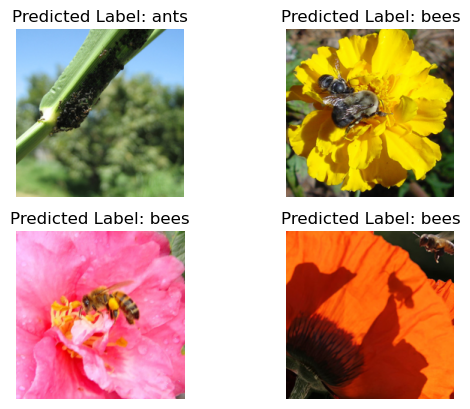

In [13]:
#Visualize some predictions:
 
import matplotlib.pyplot as plt

# Initialize a figure for visualization
fig = plt.figure()
shown_batch = 0
index = 0

# Disable gradient computation
with torch.no_grad():
    
    # Iterate over the validation dataset
    for (images, labels) in dataloaders['val']:
        # Limit to showing one batch
        if shown_batch == 1:
            break
        shown_batch += 1
        
        # Prepare images and labels
        images = Variable(images)
        labels = Variable(labels)
        
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        # Get model outputs
        outputs = model_conv(images)                            #The output is of shape (4,2)
        _, preds = torch.max(outputs, 1)                        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        
        # Loop over images in the batch
        for i in range(4):  # Assuming batch size is 4
            index += 1
            ax = plt.subplot(2,2,index)  # Arrange images in a 2x2 grid
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            
            # Process the image for displaying:
            input_img = images.cpu().data[i]                    # Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        # If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean # Unnormalize the image
            
            inp = np.clip(inp, 0, 1) # Clip values to be between 0 and 1
            plt.imshow(inp)          # Display the image